# Exp-09 폐렴 진단

- 프로젝트 부분은 페이지 검색으로 '프로젝트'를 찾아주세요.
- 정확도 지표를 달성한 모델은 'model8_2'입니다.

# 예제 실습

## 1. 준비

In [70]:
plt.style.use(['dark_background'])

In [71]:
import os
import glob

!pwd

/aiffel/aiffel/Exploration/Pneumonia_diagnosis


In [72]:
path = '/aiffel/aiffel/Exploration/Pneumonia_diagnosis/'

In [73]:
!mkdir -p ./chest_xray

In [74]:
os.listdir(path)

['chest_xray',
 '[E-09]Pneumonia_diagnosis.ipynb',
 'image-22.png',
 '.ipynb_checkpoints']

In [75]:
!ln -s ~/data/ ./chest_xray

ln: failed to create symbolic link './chest_xray/data': File exists


In [76]:
dir_path = path + 'chest_xray/'
data_path = dir_path + 'data/'

In [77]:
os.listdir(data_path)

['test', 'train', 'val']

### 필요 라이브러리들 불러오기

In [78]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 사용할 변수 생성

In [79]:
# 경로지정
dir_path = path + 'chest_xray/'
data_path = dir_path + 'data/'

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = data_path + 'train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = data_path + '/val/*/*'
TEST_PATH = data_path + '/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


### 데이터 로드

In [80]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## 2. 전처리

### 스플릿

In [81]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(2022)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 데이터 확인

In [82]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/Exploration/Pneumonia_diagnosis/chest_xray/data/train/PNEUMONIA/person287_bacteria_1354.jpeg
Pneumonia image path
/aiffel/aiffel/Exploration/Pneumonia_diagnosis/chest_xray/data/train/PNEUMONIA/person1201_bacteria_3151.jpeg


In [83]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


### tf.data 인스턴스 생성
: 텐서플로우에서 학습시킬 때 mini batch로 작업할 수 있게 해준다.

In [84]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [85]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 라벨링

In [86]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 이미지 reshape

In [87]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [88]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [89]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [90]:
image.shape

TensorShape([180, 180, 3])

In [91]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [92]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [93]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [94]:
image_batch, label_batch = next(iter(train_ds))

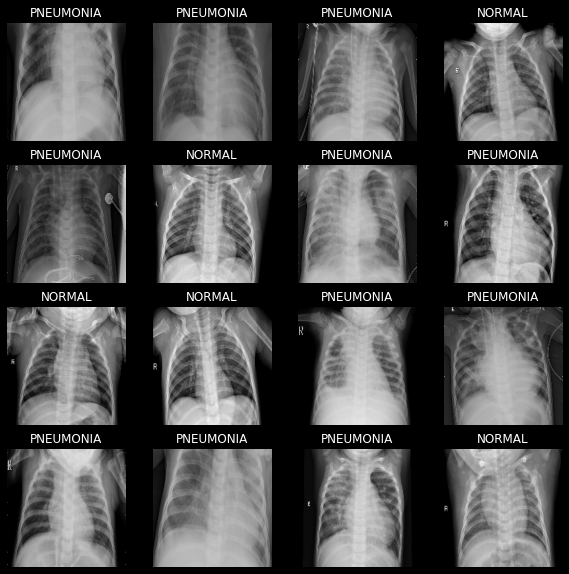

In [95]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [96]:
# a = image_batch.numpy()
# b = label_batch.numpy()
# a[0].shape

In [97]:
# show_batch(a, b)

In [98]:
image_batch.shape

TensorShape([16, 180, 180, 3])

In [99]:
label_batch.shape

TensorShape([16])

## 3. 모델링 및 학습

In [100]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [101]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [102]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [103]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [104]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [105]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 186ms/step - loss: 0.3880 - accuracy: 0.8101 - precision: 0.9555 - recall: 0.7811 - val_loss: 0.7113 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 184ms/step - loss: 0.2479 - accuracy: 0.9025 - precision: 0.9691 - recall: 0.8977 - val_loss: 1.5032 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 186ms/step - loss: 0.1942 - accuracy: 0.9308 - precision: 0.9776 - recall: 0.9282 - val_loss: 0.3562 - val_accuracy: 0.8385 - val_precision: 0.8213 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1745 - accuracy: 0.9337 - precision: 0.9793 - recall: 0.9305 - val_loss: 0.1699 - val_accuracy: 0.9375 - val_precision: 0.9916 - val_recall: 0.9228
Epoch 5/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1738 - accura

## 4. 시각화 및 분석

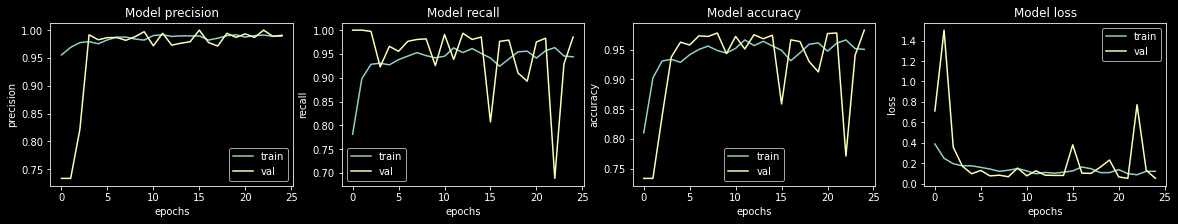

In [106]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [107]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 0.8516 - accuracy: 0.7965 - precision: 0.7604 - recall: 0.9846
Loss: 0.8515610098838806,
Accuracy: 0.7964743375778198,
Precision: 0.7603960633277893,
Recall: 0.9846153855323792


# 프로젝트 : 폐렴 진단모델 성능 개선

<br>핵심 목표<br>
- 정확도 기준 85%달성
- 평가지표의 안정적 수렴을 시각자료로 확인
- *ablation study*
<br>: 데이터 사이언스 분야의 용어로, 직역하면 '제거 학습'이다.
<br>  앞서 학습들에서 가장 난감했던 부분인데, 아니나 다를까 전문용어까지 있는 중요한 요소였다.
>
> - 데이터가 커지고 모델이 복잡해 질수록 성능에 관여하는 변인이 몹시 많다.
> - 정확한 비교를 위해서는 당연히 확인하고자 하는 변인을 제외한 나머지를 통제해야한다.
> - 이번 exp의 주요 목표 중 하나로, 고려할 만한 여러 변수들을 제시하고 있다.

## 1. 준비

### 1.1. 실습환경 준비

In [108]:
# 사용할 라이브러리

# 이런 식으로 한 줄에 여러 라이브러리를 임포트 할 수 있는 것을 처음 알았다. 기준은 뭐지...?
import os, re 
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [109]:
!pwd

/aiffel/aiffel/Exploration/Pneumonia_diagnosis


In [110]:
# 경로지정
path = '/aiffel/aiffel/Exploration/Pneumonia_diagnosis/'
dir_path = path + 'chest_xray/'
data_path = dir_path + 'data/'

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
TRAIN_PATH = data_path + 'train/*/*'
VAL_PATH = data_path + '/val/*/*'
TEST_PATH = data_path + '/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

### 1.2. 데이터 로드

In [111]:
# 텐서플로우에 glob이 있다는 것도 처음 알았다.

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## 2. 데이터 전처리

### 2.1. 스플릿

In [112]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(2022)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 2.2. 데이터 확인

In [113]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/Exploration/Pneumonia_diagnosis/chest_xray/data/train/PNEUMONIA/person287_bacteria_1354.jpeg
Pneumonia image path
/aiffel/aiffel/Exploration/Pneumonia_diagnosis/chest_xray/data/train/PNEUMONIA/person1201_bacteria_3151.jpeg


In [114]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


#### tf.data 인스턴스 생성
: 텐서플로우에서 학습시킬 때 mini batch로 작업할 수 있게 해준다.

In [115]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [116]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 2.3. 라벨링

In [117]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 2.4. 이미지 reshape

In [118]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [119]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [120]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [121]:
image.shape

TensorShape([180, 180, 3])

### 2.5. test 데이터셋 전처리

In [122]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


###  tf.data 파이프라인으로 함수지정
- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    > 이 때 대상 데이터셋을 미리 섞어주거나, 버퍼 사이즈의 크기가 데이터 총량보다 커야한다.


- repeat()를 사용하면 데이터셋을 재활용해서 학습할 수 있음. 이번 실습/프로젝트의 경우 데이터셋의 총량이 작기 때문에 유용할 것.


- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습

In [123]:
# 원본 데이터의 정렬 상태(정상/폐렴)를 확인하지는 않았으나, 셔플 과정에서 이미 랜덤시드를 사용해 섞어주었음
# 따라서 버퍼 사이즈가 전체 데이터셋 보다 크지 않아도 괜찮다.
# 하지만 프로젝트 진행 중 여러가지 튜닝을 진행할 터, 각 데이터셋의 크기와 동일한 버퍼 사이즈를 입력해주겠음
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds, 4185)
val_ds = prepare_for_training(val_ds, 1047)

### 시각화

In [124]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [125]:
image_batch, label_batch = next(iter(train_ds))

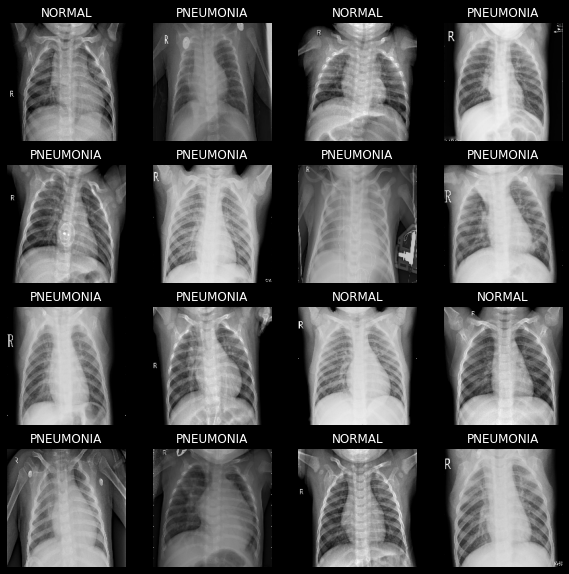

In [126]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [127]:
label_batch.shape

TensorShape([16])

## 3. 모델링 / 파인튜닝

### 앞서 정의한 모델을 다시 살펴보자

- Convolution block

        def conv_block(filters):
            block = tf.keras.Sequential([
                tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
                tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPool2D()
            ])
            
            return block

- Dense Block

        def dense_block(units, dropout_rate):
            block = tf.keras.Sequential([
                tf.keras.layers.Dense(units, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(dropout_rate)
            ])
            
            return block

### 3.1.BatchNormalization과 Dropout

각각 오버피팅을 피하기 위한 정규화(Regularization) 방법으로 사용한다.
>*BatchNormalization은 기본적으로 정규화보다 학습효율(시간)을 높이기 위한 방법이고,
<br>그 과정에서 정규화 효과가 발생하는 것이라고 한다.*

학습 단계에서 이 둘을 함께 사용하는 것에 관한 언급이 있었는데, 함께 사용하는 것이 좋지 않기도 하고 어떤 경우에는 좋기도 하다는 아리송한 내용이었다.

함께 사용하는 것이 좋지 않다는 견해의 골자는, 모델이 학습하는 도중 발생할 수 있는 variance shift(분산 이동)에 대한 문제 제기인데, BatchNormalization은 이를 억제하고 Dropout은 유발한다는 것이다.


- 분산이동
>- 우선, 공분산 이동(Covariance shift)이라는 용어를 더 많이 사용한다. 두 용어가 엄밀하게 같은 것은 아닐 가능성이 크지만, 위에서 제기하는 문제에 있어 공분산 이동이라는 용어가 딥러닝과 데이터사이언스 분야에서 일반적으로 사용되는 것 같다.
>- 역시나 수학적인 이해를 바탕으로 한 것은 아니지만, 공분산 이동의 발생은 학습 속도의 저하를 유발한다. 딥뉴럴 네트워크를 상정할 때 깊은(출력 층에 가까운) 레이어에 전달되는 정보는 많은 레이어를 거치며 분산의 형태가 다양해 지고, 이는 곧 연산량의 증가로 이어지기 때문.
>- 이를 완화하기 위해 은닉층 사이의 임의의 지점(들)에 정규분포화 레이어를 두는 것이 곧 배치노멀라이제이션이다.
>- 반대로 드롭아웃은 개별 레이어에 대해 일정 확률로 가중치 노드의 계산을 0으로 만드는 것. 당연히 배치가 반복될수록 공분산 이동이 커질 것이다.

정규화 관점에서 두 방법론은 모두, 일종의 데이터에 대한 작은 노이즈로 작용하여, 과적합을 완화해주는 것이라고 한다. 하지만 공분산 이동에 대한 영향이 정반대이니 사용하지 않는 것이 좋다는 견해에 대해서는 직관적인 납득이 가능했다.

그렇다면 이들을 함께 사용하는 것이 좋다는 견해의 논지는 무엇일까?
> BatchNormalization + Dropout
> - 이론에 앞서, 검색을 해 보면 두 방법을 함께 사용하는 경우 성능 개선에 도움이 된다는 경험적 의견이 많았음
>
> - 아래 도식에서 IC라는 레이어에 드롭아웃과 배치노멀라이제이션을 모두 포함시키는 것이 성능 향상과 학습 비용의 효율 측면에서 뛰어나다는 것이 학습 단계에 소개된 논문의 핵심.
> ![](./image-22.png)
>
> 그런데 예제 모델의 구성이 저 IC레이어에 해당하는가에 대해서는 의구심이 든다.
>
> 그에 대한 확신을 떠나, 우리가 사용할 데이터셋의 크기는 샘플의 수가 상당히 적은 편이다.
>
> 거의 (full)batch GD를 진행해도 괜찮지 않은가 싶은 크기이며, 미니배치로 진행하더라도 텐서플로우 fit의 기본값인 32보다는 일반적으로 사용하는 배치사이즈 중 가장 큰 512로 접근하는 것이 좋다고 생각된다.
>
> 그런데 모델 효율 향상 뿐 아니라 정규화의 관점에서도, 배치노멀라이제이션과 드롭아웃은 모두 총 학습 batch가 많아질 때 효과가 커지는 경향이 있다고 한다.
> - 노멀라이제이션의 경우 1 batch에 해당하는 데이터가 통과할 때마다 분산을 일정하게 조절해주는 것이니 당연히 그렇다.
> - 드롭아웃의 경우 학습횟수가 적다면 앞서의 '공분산 이동'이 과하게 발생할 수 있을 것 같다.

### 3.1.에 대해 시도해 볼 것
- 우선 각각을 배제하고 학습시켜보고 비교한다.
- 각각에 대해 batch size를 512로 두고 차이를 확인해본다.
- 예제와 같은 조건에서 드롭아웃 레이어의 갯수와 하이퍼파라미터를 조절해본다.

### 3.2. 가중치 초기화 파라미터 He로 변경
위의 드롭아웃이나 노멀라이제이션에 관한 정보에서 대부분의 경우 언급되는 사항이 가중치 초기화에 과한 영향을 받지 않는다는 것이다. 


가중치 초기화가 모델 개선에서 주요한 역할을 할 수 있음을 앞서의 챕터들에서 배웠다. 하지만 학습 초기부터 과적합이 일어나는 등의 역효과를 감안할 역량이 안되면 사용하기 어렵다는 인상이 강했다. 물론 API 모델을 이용하는 경우 가중치 초기값이 설정되어 있지만, 하이퍼 파라미터를 조절하는 것 역시 마찬가지의 부담이 있었다.


이런 부분을 드롭아웃이나 노멀라이제이션과 같은 일반화(또는 규제)가 어느 정도 해소해주는 듯하니 사용해보려고한다.


relu 활성화 함수를 사용하는 레이어의 대부분에 'He' 이니셜라이저가 잘 작동한다고 하여 채택
> - HeNormal과 HeUniform 두 가지가 있다.
> - He 뿐만 아니라 대부분의 이니셜라이저가 Normal Distribution과 Uniform Distribution 두 가지 종류를 가진다고 한다.
> - 개별 이니셜라이저의 구조는 모르지만, 각각 정규분포와 연속균등분포를 기반(?)으로 하는 것이 구분점.
> - CNN모델에서는 정규분포를 기반으로하는 이니셜라이저가 일반적으로 더 잘 기능한다는 듯

## 4. 학습 및 분석

### 4.1. 배치정규화 / 드롭아웃 조절

### 4.1.1. 배치정규화 제거

In [61]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#       tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
#       tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [62]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [63]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [64]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [65]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 81s 192ms/step - loss: 0.6939 - accuracy: 0.4947 - precision: 0.7408 - recall: 0.4939 - val_loss: 0.6993 - val_accuracy: 0.2673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.6943 - accuracy: 0.5002 - precision: 0.7283 - recall: 0.5237 - val_loss: 0.6889 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 190ms/step - loss: 0.6939 - accuracy: 0.5206 - precision: 0.7413 - recall: 0.5460 - val_loss: 0.6995 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
261/261 [==============================] - 50s 190ms/step - loss: 0.6931 - accuracy: 0.5034 - precision: 0.7317 - recall: 0.5267 - val_loss: 0.6988 - val_accuracy: 0.2673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
261/261 [==============================] - 51s 195ms/step

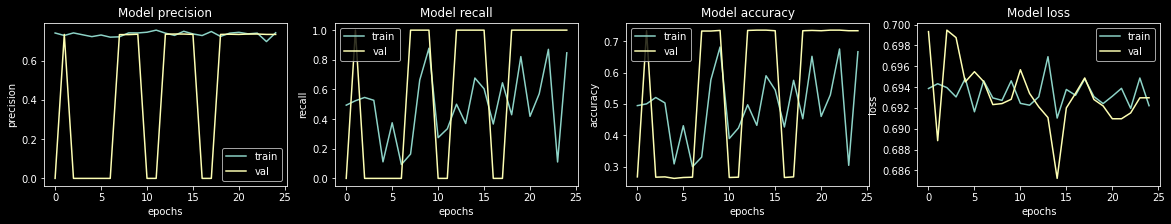

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 114ms/step - loss: 0.6931 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6930549144744873,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### 분석
- 결과 지표는 수치도 시각화된 차트도 좋지 못했다.
- 벨리데이션 셋의 그래프 형태를 보면 더 많은 학습 주기를 반복하면 안정적으로 수렴할 가능성도 있어 보인다.
- 하지만 효율적인 접근은 아니니 이 경우는 우선 배제

### 4.1.2. 드롭아웃 제거

In [68]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
#       tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [69]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [70]:
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [71]:
with tf.device('/GPU:0'):
    history = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 83s 193ms/step - loss: 0.2366 - accuracy: 0.9009 - precision: 0.9726 - recall: 0.8919 - val_loss: 0.7085 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1617 - accuracy: 0.9392 - precision: 0.9805 - recall: 0.9369 - val_loss: 1.4043 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1122 - accuracy: 0.9610 - precision: 0.9897 - recall: 0.9575 - val_loss: 0.0960 - val_accuracy: 0.9635 - val_precision: 0.9905 - val_recall: 0.9594
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1025 - accuracy: 0.9646 - precision: 0.9901 - recall: 0.9620 - val_loss: 0.3799 - val_accuracy: 0.8548 - val_precision: 1.0000 - val_recall: 0.8026
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1211 - accura

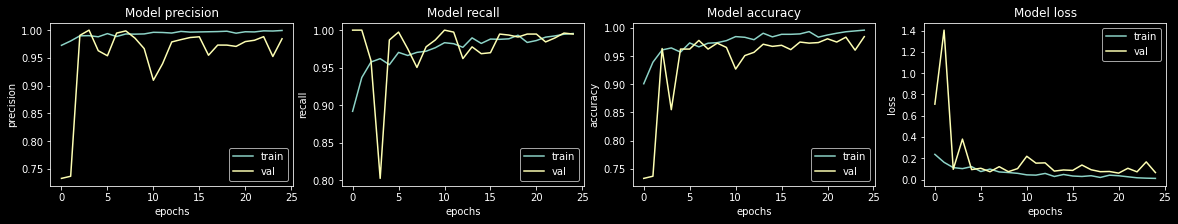

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [73]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.5198 - accuracy: 0.7692 - precision: 0.7312 - recall: 0.9974
Loss: 1.519839882850647,
Accuracy: 0.7692307829856873,
Precision: 0.731203019618988,
Recall: 0.9974358677864075


### 분석
- 벨리데이션 셋의 지표가 비교적 안정적이다.
- 하지만 학습 지표에 비해 테스트 결과가 형편없다. 오버피팅의 방지에는 드롭아웃의 유효성이 확실해 보인다.

### 4.1.3. 배치 정규화 제거 및 배치 사이즈 512

In [74]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#       tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
#       tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [75]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [76]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [77]:
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [78]:
BATCH_SIZE = 512

with tf.device('/GPU:0'):
    history = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
8/8 [==============================] - 41s 1s/step - loss: 0.6948 - accuracy: 0.2734 - precision: 0.7500 - recall: 0.0316 - val_loss: 0.6955 - val_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 9s 1s/step - loss: 0.7246 - accuracy: 0.3984 - precision: 0.7059 - recall: 0.2637 - val_loss: 0.6939 - val_accuracy: 0.1562 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 9s 1s/step - loss: 0.6617 - accuracy: 0.3984 - precision: 0.8667 - recall: 0.2626 - val_loss: 0.6933 - val_accuracy: 0.4062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
8/8 [==============================] - 9s 1s/step - loss: 0.6798 - accuracy: 0.4844 - precision: 0.8298 - recall: 0.4021 - val_loss: 0.6853 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 9s 1s/step - loss: 0.6953 - accuracy: 0.5078 - pr

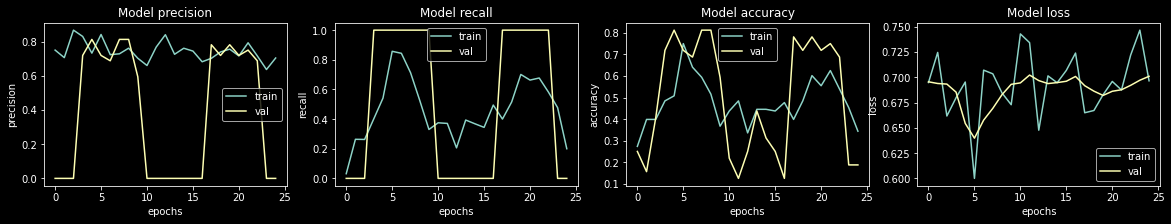

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [80]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 0.6963 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6963199973106384,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


### 분석
- 드롭아웃은 큰 배치에서 유효하지 않을 뿐더러, 오히려 좋지 않은 영향을 끼친다.
- 드롭아웃을 제거하는 학습도 큰 기대가 되지 않지만 비교를 위해 진행

### 4.1.4. 드롭아웃 제거 및 배치 사이즈 512

In [81]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
#       tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [82]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [83]:
with tf.device('/GPU:0'):
    model4 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [84]:
with tf.device('/GPU:0'):
    history = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
8/8 [==============================] - 42s 1s/step - loss: 0.5715 - accuracy: 0.7109 - precision: 0.9420 - recall: 0.6633 - val_loss: 0.6874 - val_accuracy: 0.6562 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 9s 1s/step - loss: 0.3478 - accuracy: 0.8750 - precision: 0.9367 - recall: 0.8706 - val_loss: 0.6967 - val_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 9s 1s/step - loss: 0.2957 - accuracy: 0.8438 - precision: 0.9870 - recall: 0.8000 - val_loss: 0.7068 - val_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
8/8 [==============================] - 9s 1s/step - loss: 0.2846 - accuracy: 0.8828 - precision: 0.9634 - recall: 0.8681 - val_loss: 0.7124 - val_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
8/8 [==============================] - 9s 1s/step - loss: 0.4184 - accuracy: 0.8125 - pr

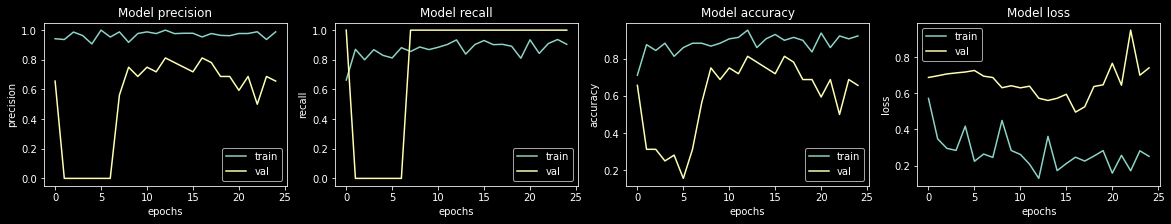

In [85]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [86]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.7916 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.7916260957717896,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### 분석
- 큰 배치사이즈에서 배치정규화의 

### 4.1.5. 드롭아웃 튜닝

In [87]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [88]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [89]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [90]:
with tf.device('/GPU:0'):
    model5 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model5.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [91]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model5.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 82s 191ms/step - loss: 0.4148 - accuracy: 0.7878 - precision: 0.9476 - recall: 0.7567 - val_loss: 0.5988 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2437 - accuracy: 0.8987 - precision: 0.9702 - recall: 0.8912 - val_loss: 1.1747 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2305 - accuracy: 0.9162 - precision: 0.9723 - recall: 0.9135 - val_loss: 1.0067 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1891 - accuracy: 0.9270 - precision: 0.9801 - recall: 0.9206 - val_loss: 0.8049 - val_accuracy: 0.7356 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1684 - accura

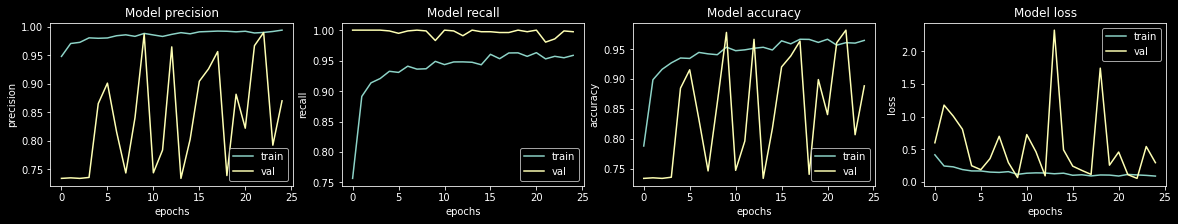

In [92]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [93]:
loss, accuracy, precision, recall = model5.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.9508 - accuracy: 0.6683 - precision: 0.6533 - recall: 1.0000
Loss: 1.9508365392684937,
Accuracy: 0.6682692170143127,
Precision: 0.6532663106918335,
Recall: 1.0


### 분석
- 조금 더 많은 학습 주기가 필요해 보인다. 
- 예상보다 더 불규칙한 벨리데이션셋의 학습률.
- 아무래도 아예 한 개의 층이 더 생긴 것이 영향이 큰 것 같다.
- 이 부분은 지난 exp에서도 확인하고 싶었던 부분이니 약간의 변형을 가해 한 번더 확인 할 것

### 4.1.6. 드롭아웃 튜닝(2)
- 나머지를 실습 모델과 동일하게 두고, 드롭아웃 레이어를 인풋 레이어에 가깝게 배치해본다.


In [94]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [95]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [96]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [98]:
with tf.device('/GPU:0'):
    model6 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model6.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [99]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model6.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 83s 194ms/step - loss: 0.4104 - accuracy: 0.7924 - precision: 0.9509 - recall: 0.7602 - val_loss: 0.5795 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2684 - accuracy: 0.8891 - precision: 0.9668 - recall: 0.8813 - val_loss: 1.2372 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2277 - accuracy: 0.9143 - precision: 0.9702 - recall: 0.9127 - val_loss: 1.2027 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 194ms/step - loss: 0.2052 - accuracy: 0.9179 - precision: 0.9769 - recall: 0.9112 - val_loss: 0.3288 - val_accuracy: 0.8788 - val_precision: 0.9969 - val_recall: 0.8375
Epoch 5/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1792 - accura

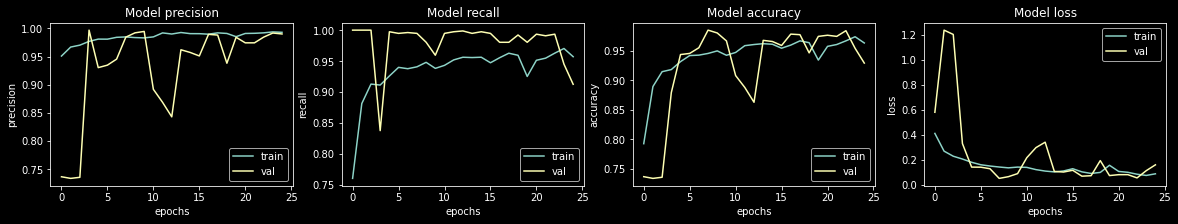

In [100]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [101]:
loss, accuracy, precision, recall = model6.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 127ms/step - loss: 0.9189 - accuracy: 0.7692 - precision: 0.7552 - recall: 0.9333
Loss: 0.918908417224884,
Accuracy: 0.7692307829856873,
Precision: 0.7551867365837097,
Recall: 0.9333333373069763


### 분석
- 기본 셋팅과 비교해 학습 안정화에 접어드는 시기가 조금 늦었으나 점수 지표는 조금 더 높게 획득했다.
- 기본 셋팅과 현재의 경우 모두 약 20epoch 전후로 큰 향상이 없는 것으로 보인다.
- 동일 기준에서 20epoch 학습을 확인

### 4.1.7. 드롭아웃 튜닝(3)
위 모델6의 epoch조절

In [29]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [30]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [31]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [32]:
with tf.device('/GPU:0'):
    model6 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model6.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [33]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model6.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=20,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 99s 210ms/step - loss: 0.4159 - accuracy: 0.7852 - precision: 0.9462 - recall: 0.7539 - val_loss: 0.6227 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 50s 191ms/step - loss: 0.2404 - accuracy: 0.8994 - precision: 0.9696 - recall: 0.8928 - val_loss: 1.9358 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 50s 192ms/step - loss: 0.2200 - accuracy: 0.9112 - precision: 0.9724 - recall: 0.9066 - val_loss: 1.6535 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 51s 196ms/step - loss: 0.1822 - accuracy: 0.9320 - precision: 0.9806 - recall: 0.9268 - val_loss: 0.0890 - val_accuracy: 0.9721 - val_precision: 0.9829 - val_recall: 0.9791
Epoch 5/20
261/261 [==============================] - 52s 201ms/step - loss: 0.1503 - accura

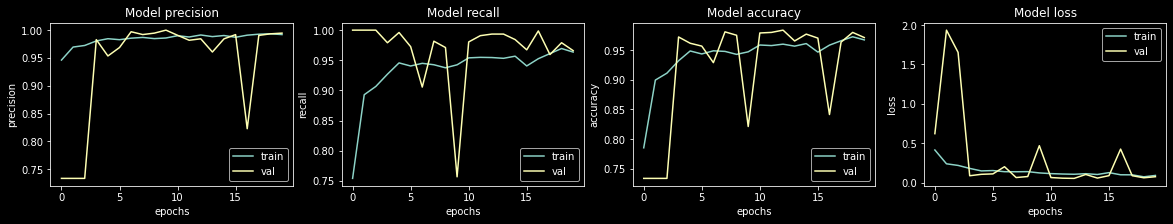

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
loss, accuracy, precision, recall = model6.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

NameError: name 'model6' is not defined

### 분석
- 현재까지 학습 중 가장 높은 정확도를 얻었고, 리콜도 준수하다.

### 4.1.7. 드롭아웃 튜닝(4)
- 드롭아웃 레이어 분산 및 비율 조절

In [29]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [30]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [31]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [32]:
with tf.device('/GPU:0'):
    model7 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model7.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [33]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model7.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 94s 193ms/step - loss: 0.3790 - accuracy: 0.8202 - precision: 0.9538 - recall: 0.7970 - val_loss: 0.7640 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2286 - accuracy: 0.9102 - precision: 0.9723 - recall: 0.9050 - val_loss: 1.7270 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1969 - accuracy: 0.9265 - precision: 0.9785 - recall: 0.9215 - val_loss: 0.0977 - val_accuracy: 0.9615 - val_precision: 0.9653 - val_recall: 0.9830
Epoch 4/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1773 - accuracy: 0.9353 - precision: 0.9813 - recall: 0.9308 - val_loss: 0.3802 - val_accuracy: 0.8221 - val_precision: 0.8051 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 53s 202ms/step - loss: 0.1695 - accura

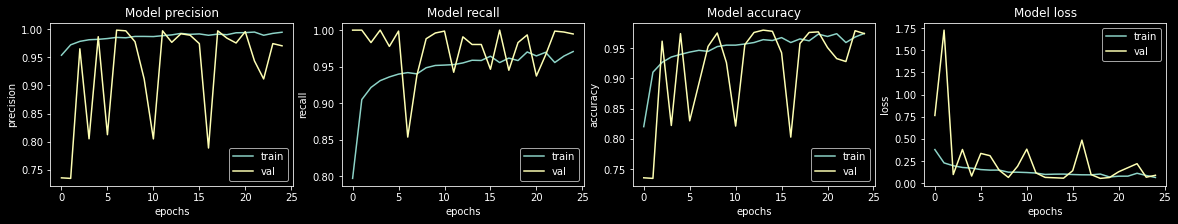

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
loss, accuracy, precision, recall = model7.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.4736 - accuracy: 0.7324 - precision: 0.7009 - recall: 0.9974
Loss: 1.47358238697052,
Accuracy: 0.7323718070983887,
Precision: 0.7009009122848511,
Recall: 0.9974358677864075


### 분석
- 학습 대비 테스트 점수의 지표가 저조하다. 벨리데이션셋까지 과적합이 일어난 것일까?
- 5epoch을 덜 학습 시킨 것이 영향이 있었을 것도 같으나 차이를 매꾸지는 못했을 것 같다.
- 다만 리콜 점수가 높게 나왔다는 점이, 의료진단 데이터셋으로서는 유의미한 지표일 수 있을 것 같다.

### 4.1.8. 드롭아웃 튜닝 - batch size 32

In [36]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [37]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [38]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [39]:
with tf.device('/GPU:0'):
    model8 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model8.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [40]:
BATCH_SIZE = 32

with tf.device('/GPU:0'):
    history = model8.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=45,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/45
130/130 [==============================] - 60s 222ms/step - loss: 0.4323 - accuracy: 0.7923 - precision: 0.9464 - recall: 0.7578 - val_loss: 0.5842 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/45
130/130 [==============================] - 28s 220ms/step - loss: 0.2770 - accuracy: 0.8880 - precision: 0.9754 - recall: 0.8751 - val_loss: 0.7544 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 3/45
130/130 [==============================] - 29s 221ms/step - loss: 0.2526 - accuracy: 0.9034 - precision: 0.9628 - recall: 0.9048 - val_loss: 1.0131 - val_accuracy: 0.7207 - val_precision: 0.7207 - val_recall: 1.0000
Epoch 4/45
130/130 [==============================] - 28s 220ms/step - loss: 0.2395 - accuracy: 0.9087 - precision: 0.9721 - recall: 0.9028 - val_loss: 1.3855 - val_accuracy: 0.7207 - val_precision: 0.7207 - val_recall: 1.0000
Epoch 5/45
130/130 [==============================] - 30s 228ms/step - loss: 0.2085 - accura

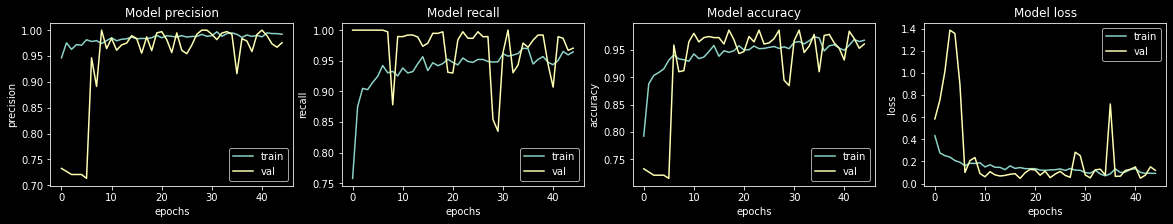

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, accuracy, precision, recall = model8.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 105ms/step - loss: 1.0265 - accuracy: 0.7660 - precision: 0.7337 - recall: 0.9821
Loss: 1.0264705419540405,
Accuracy: 0.7660256624221802,
Precision: 0.7337164878845215,
Recall: 0.9820512533187866


### 배치정규화 / 드롭아웃 조절 요약
결과
- model6, 20epoch이 가장 괜찮은 지표를 보여주었다.
    > loss: 0.6232 - accuracy: 0.8317 - precision: 0.8000 - recall: 0.9744



문제점 : 학습 결과의 신뢰도가 낮다?
- 커널 다운을 자주 당해 본의 아니게 완전히 동일한 코드를 여러 번 학습하게 된 경우가 있었다.
- 그런데, 드롭아웃이 가진 무작위성 때문인지, 동일 조건 동일 코드에서 학습 결과의 편차가 적지않았다.
- 작은 데이터셋에, repeat메소드의 사용이 원인이라는 생각이 든다. 하지만 이번 프로젝트으 경우 데이터셋이 작다는 것 자체가 해결과제이므로 우선 진행하도록 하겠다.


In [43]:
model6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
dropout (Dropout)            (None, 180, 180, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)      

### 4.2. 가중치 초기화 적용

### 4.2.1. model6(20epoch)에 적용(1)

In [28]:
initializer = tf.keras.initializers.HeNormal()

In [39]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', kernel_initializer=initializer, padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', kernel_initializer=initializer, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [40]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer, padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [41]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [42]:
with tf.device('/GPU:0'):
    model7 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model7.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [43]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model7.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=20,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 88s 192ms/step - loss: 0.3707 - accuracy: 0.8159 - precision: 0.9602 - recall: 0.7849 - val_loss: 0.6288 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 49s 188ms/step - loss: 0.2216 - accuracy: 0.9126 - precision: 0.9747 - recall: 0.9060 - val_loss: 1.2075 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 49s 189ms/step - loss: 0.2051 - accuracy: 0.9260 - precision: 0.9761 - recall: 0.9230 - val_loss: 0.7285 - val_accuracy: 0.7394 - val_precision: 0.7387 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 50s 190ms/step - loss: 0.1725 - accuracy: 0.9303 - precision: 0.9815 - recall: 0.9237 - val_loss: 0.2332 - val_accuracy: 0.9067 - val_precision: 0.8912 - val_recall: 0.9948
Epoch 5/20
261/261 [==============================] - 51s 196ms/step - loss: 0.1548 - accura

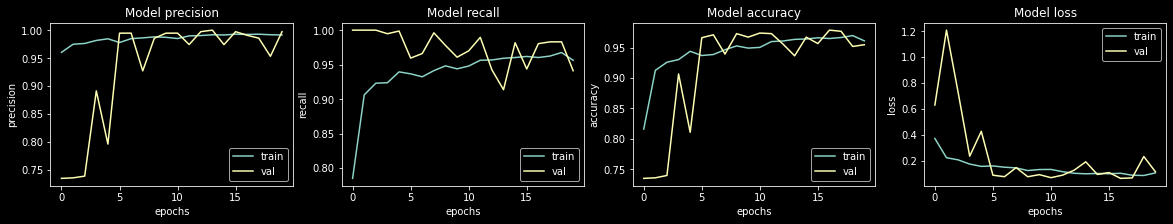

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
loss, accuracy, precision, recall = model7.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 101ms/step - loss: 0.5105 - accuracy: 0.8446 - precision: 0.8164 - recall: 0.9692
Loss: 0.5104716420173645,
Accuracy: 0.8445512652397156,
Precision: 0.8164147138595581,
Recall: 0.9692307710647583


### 분석 
- 효과가 있었다. 약간 더 나은 지표를 보여주고 있음.
- 시각화 자룔를 볼 때 이 경우 학습량을 조금 늘려도 괜찮을 것 같다.
- 이후 이니셜라이저는 he_norm으로 쭉 진행할 것

### 4.2.1. model7에서 dropout 레이어 분산 재실험

In [128]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', kernel_initializer=initializer, padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', kernel_initializer=initializer, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [129]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer, padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [130]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [131]:
with tf.device('/GPU:0'):
    model8_2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model8_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [67]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model8_2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 188ms/step - loss: 0.4029 - accuracy: 0.7965 - precision: 0.9548 - recall: 0.7623 - val_loss: 0.7229 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 185ms/step - loss: 0.2401 - accuracy: 0.9001 - precision: 0.9736 - recall: 0.8898 - val_loss: 1.6861 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2062 - accuracy: 0.9191 - precision: 0.9756 - recall: 0.9141 - val_loss: 0.9337 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1684 - accuracy: 0.9358 - precision: 0.9817 - recall: 0.9312 - val_loss: 0.1194 - val_accuracy: 0.9558 - val_precision: 0.9465 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1510 - accura

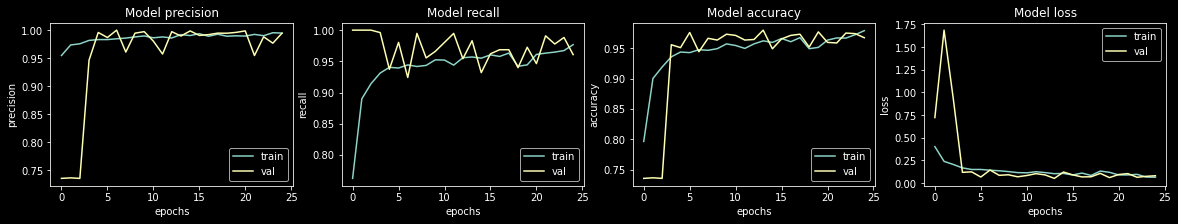

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [69]:
loss, accuracy, precision, recall = model8_2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 0.6737 - accuracy: 0.8510 - precision: 0.8166 - recall: 0.9821
Loss: 0.6736737489700317,
Accuracy: 0.8509615659713745,
Precision: 0.8166311383247375,
Recall: 0.9820512533187866


### 분석
- 목표치를 달성했다!
- 분산과 별도로 가장 마지막 conv2d 레이어에 드롭아웃이 있는 것이 지표의 안정적인 수렴에 영향을 미치는 것 같다.

### 4.3. 데이터 증식(Data augmentation) 사용해보기
- 데이터를 랜덤으로 좌-우 반전시키는 과정으로 데이터를 증식시켜 학습을 진행해본다.
- 대상은 바로 전, 가장 지표가 좋앗던 model8_2

### 4.3.1. 제시된 코드 사용

In [92]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds, 4185)
val_ds = prepare_for_training(val_ds, 1047)

In [104]:
len(image)

180

In [31]:
image_batch, label_batch = next(iter(train_ds))

In [36]:
image_batch.shape

TensorShape([16, 180, 180, 3])

In [37]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [38]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', kernel_initializer=initializer, padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', kernel_initializer=initializer, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [39]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer, padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [93]:
with tf.device('/GPU:0'):
    model9 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model9.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [94]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model9.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 81s 190ms/step - loss: 0.4344 - accuracy: 0.7835 - precision: 0.9479 - recall: 0.7502 - val_loss: 0.7717 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2480 - accuracy: 0.9004 - precision: 0.9677 - recall: 0.8961 - val_loss: 1.8743 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1967 - accuracy: 0.9236 - precision: 0.9761 - recall: 0.9197 - val_loss: 0.2787 - val_accuracy: 0.8721 - val_precision: 0.8527 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1848 - accuracy: 0.9272 - precision: 0.9769 - recall: 0.9241 - val_loss: 0.1866 - val_accuracy: 0.9202 - val_precision: 0.9040 - val_recall: 0.9974
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1849 - accura

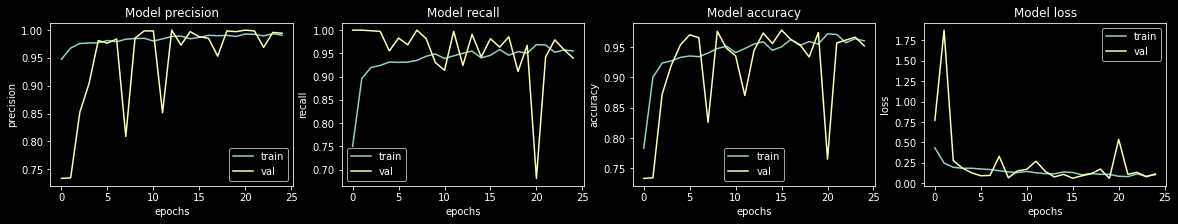

In [95]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [96]:
loss, accuracy, precision, recall = model9.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 114ms/step - loss: 0.7418 - accuracy: 0.7853 - precision: 0.7550 - recall: 0.9718
Loss: 0.741786777973175,
Accuracy: 0.7852563858032227,
Precision: 0.7549800872802734,
Recall: 0.971794843673706


### 분석
- 결과가 좋지 못하다. 
- ~~데이터를 반전시킨 것은 데이터의 형태를 다양하게 하는 목적도 있지만, 양이 충분하지 못한 원본 데이터의증식에 더 큰 목적이 있을 것인데, 데이터가 그대로인 것인 문제인 것 같다. ~~
- tf, keras에서 라이브러리에서 제공하는 증식 방법들은 맵핑된 augment에 대해 병렬적으로 학습한다고 한다. augment이 적용되고 있어도 결과적으로 epoch은 같은 것이 정상.
- 데이터 증식은 일반적으로 훈련데이터에만 적용시킨다고 하는데 동일한 처리를 하였으니 벨리데이션 셋은 이전 과정과 동일하게 프리패어링 해서 재시도해보겠음.

### 4.3.2. 데이터 증식 과정 확인 및 agumentation 조정
- 가독성 문제로 카피하지 않았지만, 이미 변형이 있었을 수 있으나 데이터를 다시 불러와주었다.

#### 이미지 확인

In [ ]:
image, label = next(iter(train_ds.take(1)))
_ = plt.imshow(image)
_ = plt.title(label.numpy())

In [120]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

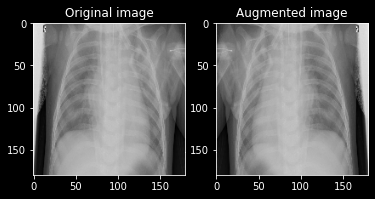

In [121]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

In [28]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  #좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds, 4185)

def prepare_for_other(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

val_ds = prepare_for_training(val_ds, 1047)

In [43]:
with tf.device('/GPU:0'):
    model10 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model10.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model10.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 112s 196ms/step - loss: 0.4212 - accuracy: 0.7850 - precision: 0.9456 - recall: 0.7545 - val_loss: 0.7298 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2543 - accuracy: 0.8956 - precision: 0.9685 - recall: 0.8887 - val_loss: 1.7588 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 194ms/step - loss: 0.2217 - accuracy: 0.9116 - precision: 0.9727 - recall: 0.9066 - val_loss: 1.0030 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1870 - accuracy: 0.9274 - precision: 0.9765 - recall: 0.9246 - val_loss: 0.1557 - val_accuracy: 0.9365 - val_precision: 0.9257 - val_recall: 0.9935
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1677 - accur

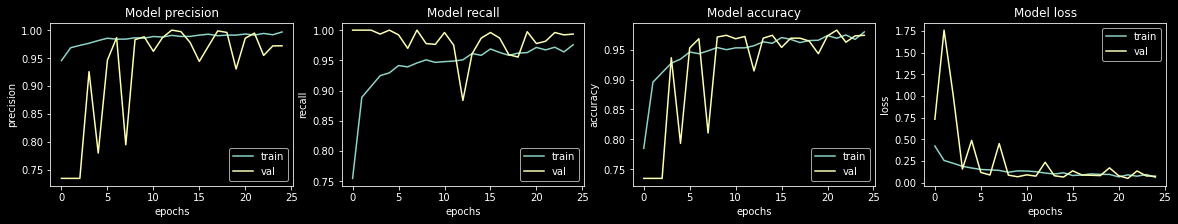

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
loss, accuracy, precision, recall = model10.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 100ms/step - loss: 1.7760 - accuracy: 0.6715 - precision: 0.6565 - recall: 0.9949
Loss: 1.775998592376709,
Accuracy: 0.6714743375778198,
Precision: 0.6565144062042236,
Recall: 0.9948717951774597


### 분석
- 학습 데이터의 수렴은 만족스러운 편이나 테스트 결과가 좋지 않다.
- 벨리데이션 셋에서도 반전된 데이터는 검증하지 않았으나 수치가 좋은데, 테스트 데이터에서는 그렇지 못하다는 것이 약간 의아하다. 사실 앞서의 훈련들에서도 비슷한 양상을 보였는데, 벨리데이션 셋의 비율을 조절하는 것이 유의미한 변화를 가져오는지 확인이 필요해 보인다.

### 4.3.2.1. 벨리데이션 셋의 비율 조절


- 학습 데이터의 수는 고정이니 비슷한 비율로 맞춰주었다.


- 원본 데이터의 분할에 대해서는 여러 견해들이 있는 것으로 보인다.


- 여기에서는 해당하지 않지만 데이터가 충분히 큰 경우 검증 및 테스트 데이터의 비율을 훨씬 적게 하는 것이 좋다고 핟다. 아래 참조
    > https://brunch.co.kr/@coolmindory/31

#### 데이터 비율의 변화가 있으므로 전처리 과정 반복

In [46]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [47]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.88)
random.seed(2022)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4604
628


In [48]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [49]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4604
Validating images count: 628


In [50]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [51]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [52]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [53]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [54]:
image.shape

TensorShape([180, 180, 3])

In [55]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [120]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  #좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds, 4604)

def prepare_for_other(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

val_ds = prepare_for_other(val_ds, 628)

In [121]:
image_batch, label_batch = next(iter(train_ds))

In [122]:
image_batch.shape

TensorShape([16, 180, 180, 3])

In [102]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 2.15
Weight for PNEUMONIA: 0.74


In [25]:
def conv_block(filters):
    block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', kernel_initializer=initializer, padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', kernel_initializer=initializer, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

    return block

In [26]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer, padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [123]:
with tf.device('/GPU:0'):
    model11 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model11.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [124]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model11.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
287/287 [==============================] - 81s 166ms/step - loss: 0.4148 - accuracy: 0.8158 - precision: 0.9538 - recall: 0.7909 - val_loss: 0.7334 - val_accuracy: 0.7276 - val_precision: 0.7276 - val_recall: 1.0000
Epoch 2/25
287/287 [==============================] - 48s 166ms/step - loss: 0.2613 - accuracy: 0.9079 - precision: 0.9713 - recall: 0.9027 - val_loss: 1.6832 - val_accuracy: 0.7276 - val_precision: 0.7276 - val_recall: 1.0000
Epoch 3/25
287/287 [==============================] - 48s 168ms/step - loss: 0.1961 - accuracy: 0.9312 - precision: 0.9796 - recall: 0.9269 - val_loss: 0.1341 - val_accuracy: 0.9471 - val_precision: 0.9448 - val_recall: 0.9845
Epoch 4/25
287/287 [==============================] - 49s 169ms/step - loss: 0.2072 - accuracy: 0.9310 - precision: 0.9766 - recall: 0.9295 - val_loss: 0.2996 - val_accuracy: 0.8814 - val_precision: 0.9897 - val_recall: 0.8455
Epoch 5/25
287/287 [==============================] - 49s 172ms/step - loss: 0.1893 - accura

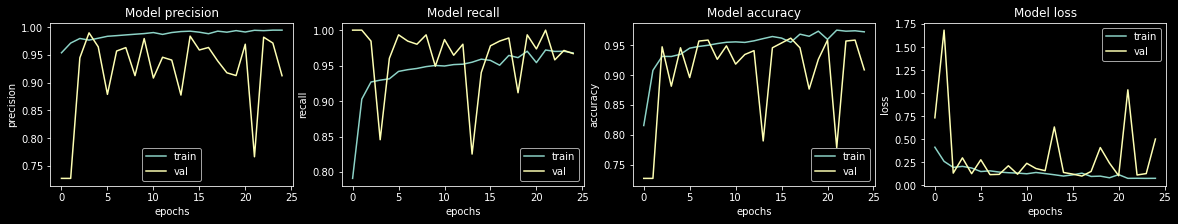

In [125]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [126]:
loss, accuracy, precision, recall = model11.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 1.9868 - accuracy: 0.7147 - precision: 0.6900 - recall: 0.9872
Loss: 1.9868026971817017,
Accuracy: 0.7147436141967773,
Precision: 0.6899641752243042,
Recall: 0.9871794581413269


In [126]:
loss, accuracy, precision, recall = model11.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 1.9868 - accuracy: 0.7147 - precision: 0.6900 - recall: 0.9872
Loss: 1.9868026971817017,
Accuracy: 0.7147436141967773,
Precision: 0.6899641752243042,
Recall: 0.9871794581413269


### 분석
- 최종 결과가 목표에 미치지는 못했으나 분명한 향상이 있었다.
- 결과적으로 이 데이터셋에서 데이터 증식은 효과를 기대하기 어려워 보인다.
- 데이터셋의 비율을 바꾸는 것이 유효하였으니, 앞서 결과가 가장 좋았던 모델에 적용시켜보자.

### 4.4. model8에 대한 데이터 스플릿 비율 조절

In [56]:
#### 파이프라인 재설정
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds, 4604)
val_ds = prepare_for_training(val_ds, 628)

In [57]:
image_batch, label_batch = next(iter(train_ds))

In [58]:
image_batch.shape

TensorShape([16, 180, 180, 3])

In [59]:
with tf.device('/GPU:0'):
    model12 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model12.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [60]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model12.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
287/287 [==============================] - 112s 169ms/step - loss: 0.3733 - accuracy: 0.8062 - precision: 0.9566 - recall: 0.7747 - val_loss: 0.7847 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 2/25
287/287 [==============================] - 48s 166ms/step - loss: 0.2212 - accuracy: 0.9131 - precision: 0.9715 - recall: 0.9098 - val_loss: 1.4724 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 3/25
287/287 [==============================] - 48s 168ms/step - loss: 0.1850 - accuracy: 0.9297 - precision: 0.9787 - recall: 0.9257 - val_loss: 0.2422 - val_accuracy: 0.8830 - val_precision: 0.8626 - val_recall: 0.9978
Epoch 4/25
287/287 [==============================] - 49s 169ms/step - loss: 0.1635 - accuracy: 0.9334 - precision: 0.9811 - recall: 0.9283 - val_loss: 0.4187 - val_accuracy: 0.8077 - val_precision: 0.7913 - val_recall: 1.0000
Epoch 5/25
287/287 [==============================] - 50s 175ms/step - loss: 0.1469 - accur

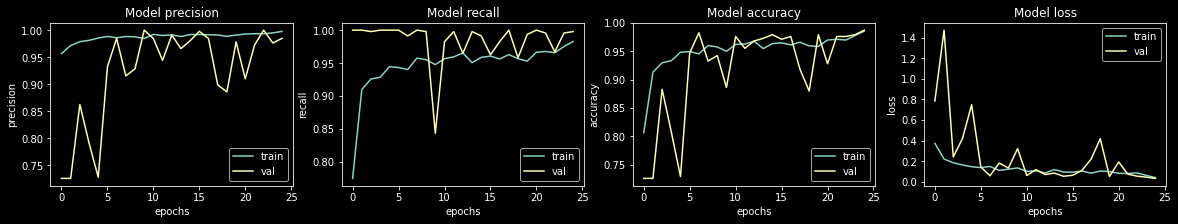

In [61]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
loss, accuracy, precision, recall = model12.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 1.4240 - accuracy: 0.7468 - precision: 0.7125 - recall: 0.9974
Loss: 1.423962950706482,
Accuracy: 0.7467948794364929,
Precision: 0.7124541997909546,
Recall: 0.9974358677864075


### 분석? 이 문제가 아니라
- 결과가 이상할 만큼 좋지 않아, 제발 아니길 바라며 모델 8_2를 이전 조건과 동일하게 재실행 해보았다.

In [132]:
BATCH_SIZE = 16

with tf.device('/GPU:0'):
    history = model8_2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 82s 193ms/step - loss: 0.4083 - accuracy: 0.7783 - precision: 0.9572 - recall: 0.7346 - val_loss: 0.5845 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2349 - accuracy: 0.9033 - precision: 0.9754 - recall: 0.8926 - val_loss: 1.8968 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1960 - accuracy: 0.9217 - precision: 0.9780 - recall: 0.9153 - val_loss: 0.3978 - val_accuracy: 0.7952 - val_precision: 0.7823 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1840 - accuracy: 0.9291 - precision: 0.9789 - recall: 0.9247 - val_loss: 0.1365 - val_accuracy: 0.9490 - val_precision: 0.9972 - val_recall: 0.9332
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1546 - accura

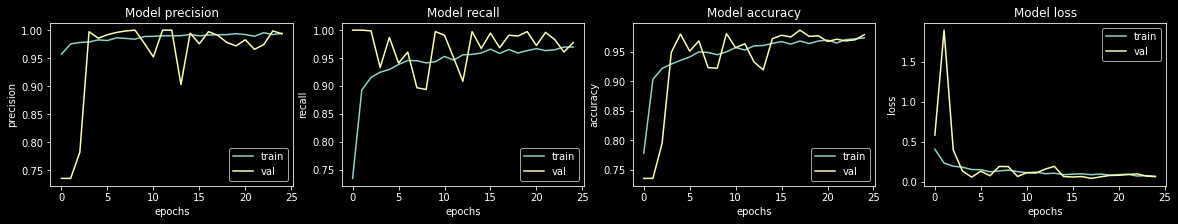

In [133]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [134]:
loss, accuracy, precision, recall = model8_2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 111ms/step - loss: 1.1773 - accuracy: 0.7724 - precision: 0.7375 - recall: 0.9872
Loss: 1.1772531270980835,
Accuracy: 0.7724359035491943,
Precision: 0.7375478744506836,
Recall: 0.9871794581413269


### 이번 익스플로레이션의 모델 최적화는 여기서 마치겠음.
학습 시간은 길고, 확인해 볼 요소들은 많다. 앞서 실습들에서도 겪은 어려움이었고,

그 과정을 차근차근 진행하는 것이 이번 exp의 주요 목표 중 하나라는 점이었다.

그래서 작은 변화를 주어도 동일한 조건에서 학습시키고, 기록했다.

그 과정에서 커널이 갑자기 사망한 경우만 10회 가까이 되는데, 마지막 3회 분 인근에서도 커널이 죽었엇다.

결과적으로 완전히 같은 조건의 모델을 재실행 했음에도 정확도 기준 0.8 가량의 차이가 났다.

랜덤시드를 사용했음에도, 셔플이나 repeat()메소드의 사용이 원인일 수 있겠다는 추론이 현재로써 최선이다.

추후 퍼실 분들과 동료 학생 분들께 질문을 해보아야 겠다.

---
하지만, 그럼에도, 편차가 너무 크다.

이런 상황에서 지표 향상을 위한 파인튜닝을 진행한들, 지표에 대한 신뢰도가 너무 떨어진다고 판단하였다.

## 5. 마치며
상심이 큽니다...<br>

<br>

### 기억에 남는 학습 내용
- 배치노멀라이제이션
- 드롭아웃
- 둘을 함께 사용하는 것에 관한 여러 견해들
- tf.image를 통한 Data augmentation이 데이터의 수를 늘리지 않고, agument에 대한 병렬 연산으로 이루어진다는 점

### 어려웠던 점
- 실습 부분에 제시된 배치노멀라이제이션+드롭아웃에 대한 논문에서, IC레이어에 관한 부분
> 실습에 제시된 모델은 IC레이어를 구성한 것이 맞는지, 아닌지 판단이 어렵다.
- 학습 시간(..)

### 추가로 해보고 싶은 점
- 기록으로 남기지는 않았으나, full-batch GD를 시행한 지표가 궁금하여 
<br>batch_size와 step_per_epoch의 수치를 조절해 1회 학습을 시도해보았었다.
<br>하지만 이것이 유효한 방법이 아니라는 생각이 들었다. 무엇보다 학습 시간이 지나치게 짧았다.
<br>이후 생각해보니, 옵티마이저 설정 자체가 mini batch 학습에 대한 최적화 함수인데..
<br>시간도 부족하고, 내상(?)도 크게 입은 상태여서 진행까지는 시키지 못했다.
<br>이에 대한 문제를 해결하기 위해 정보를 찾던 중, input data의 크기에 대해 고찰해보게 되었다.
> 검증용 분할 이전, 원본 학습 데이터는 약 5200장의 이미지 파일이다. 전체 경사하강법을 시행하기에 적절한 경우는 데이터의 크기가 4~5천개 이하일 때라는 내용을 들었던 적이 있어, 이 과정 중 시행해보고 싶었던 것이다.<br> 그런데 이미지 파일의 input이라는 것이 애초에 WxHxC인데, 그렇다면 데이터의 크기 혹은 갯수를 근거로 학습 환경을 설정할 때 어떻게 보는 것이 맞는 것일까.

- 아무튼 batch GD를 시행해보고싶다.

- 엄밀하게 따져 이번 학습에 대한 추가학습 목표는 아니지만<br> 이후 exp를 진행할 때에는, 데이터와 모델을 변경해가며 학습시킬 때, 코드의 재사용성을 최대한 높여보고 싶다.


### 총평
: 학습 과정과 결과에 대해 나름의 분석들이 무용지물이 된 것 같아 아쉬운 마음을 지울 수 없다. 하지만 여러 번 학습을 진행하며 많은 정보를 찾게되었고 이해하기 위해 애를 썼으니, 남는 것이 있으리라고 믿어본다.

\+ 모델 학습 과정이 점점 늘어나고 있어 앞으로는 예제 실습 부분과 프로젝트 부분을 구분해서 올려야겠다.

